In [9]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


I had to use the following code to install cartopy on my machine and import the package that was needed. This is what produces the map at the bottom.

In [2]:
conda install -c conda-forge cartopy


^C

Note: you may need to restart the kernel to use updated packages.


In [44]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import xarray as xr

ds = xr.open_dataset("C:/Users/iarreola/E484/files/gistemp1200_GHCNv4_ERSSTv5.nc.gz")

ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1702, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-10-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2021-11-10 10:02:57 by SBBX_to_nc 2.0 - ILAND=1200,...

In [27]:
da = ds.sel(time=slice('2000-01-01', '2009-12-31'))
da_numpy = da.values

In [34]:
# Contract the DataArray by taking mean for each Year-Month
def mean_in_year_month(da):
    # Index of Year-Month starts at Jan 1991
    month_cnt_1991 = (da.time.dt.year.to_index() - 1991) * 12 + da.time.dt.month.to_index()
    # Assign newly defined Year-Month to coordinates, then group by it, then take the mean
    return da.assign_coords(year_month = month_cnt_1991).groupby('year_month').mean()

da_1 = mean_in_year_month(da)

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

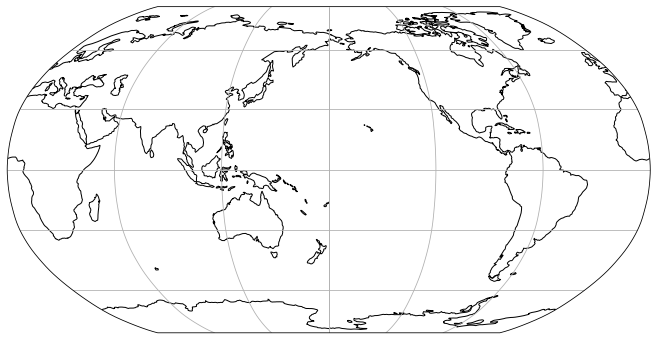

In [37]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
da_1.plot(
    robust=True, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}
)
ax.set_global()

Found a Medium article that breaks down what we need --> https://towardsdatascience.com/visualizing-climate-change-data-with-python-74ea5bac8756

First, create a time series to a yearly frequency --> climate & anomaly
Next create a static image for the global temperature anomaly for a given year --> cbar_kwargs & below

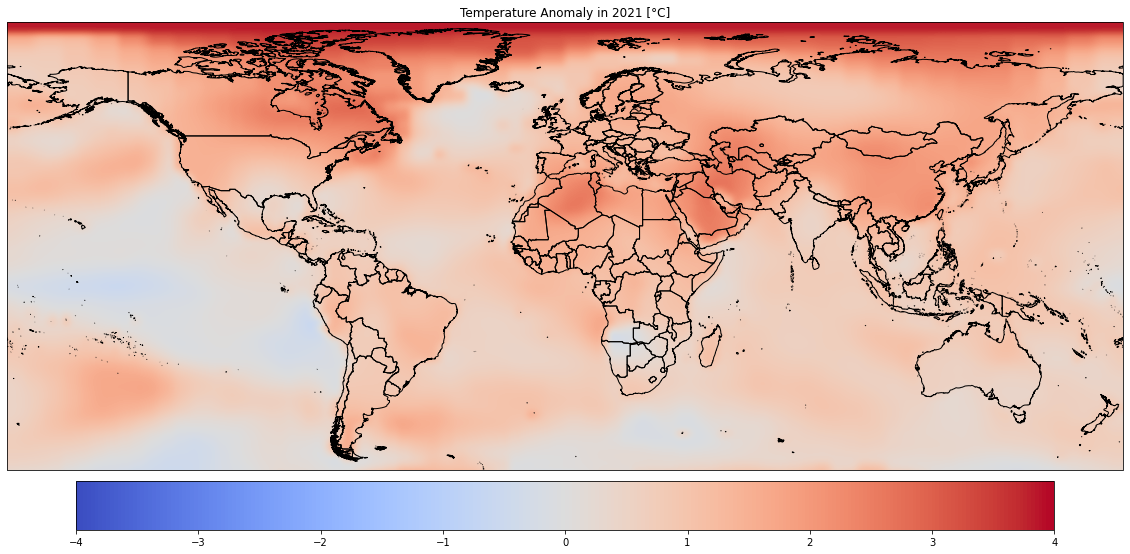

In [39]:
climate = ds.resample(time='Y').mean()
anomaly = climate['tempanomaly']

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.045,
    'pad': 0.01,
    'extend':'neither'
}

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '10m'),
                       facecolor='none', edgecolor='black')
ax.set_extent([-150, 150, -55, 85])

i=-1
date =  pd.to_datetime(anomaly.isel(time=i)['time'].values)
ax.set_title("Temperature Anomaly in "+ str(date.year) + " [°C]")
anomaly.isel(time=i).plot.imshow(ax=ax, add_labels=False, add_colorbar=True,
               vmin=-4, vmax=4, cmap='coolwarm',
               cbar_kwargs=cbar_kwargs, interpolation='bicubic')
plt.savefig("global_map.png", bbox_inches='tight', dpi=150)
plt.show()

The code below is a static image of a specific region --> european --> temperature anomaly for a given year.

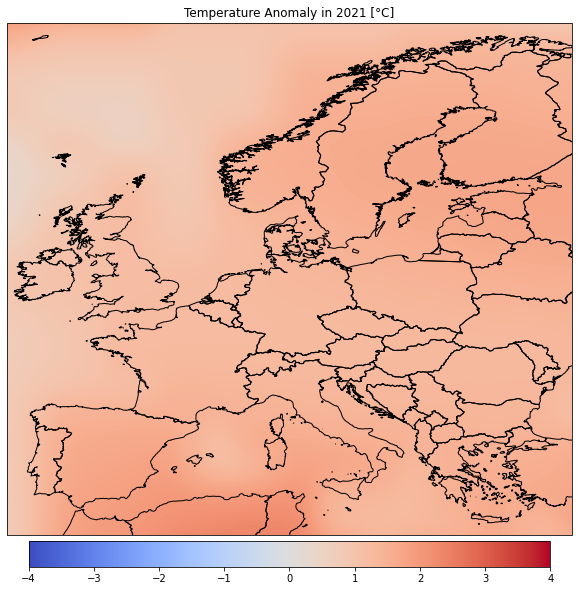

In [6]:
#Creating a static image of the european temperature anomaly for a given year.
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.048,
    'pad': 0.01,
    'extend':'neither'
}

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '10m'),
                       facecolor='none', edgecolor='black')
ax.set_extent([-11, 31, 34, 71])

i=-1
date =  pd.to_datetime(anomaly.isel(time=i)['time'].values)
ax.set_title("Temperature Anomaly in "+ str(date.year) + " [°C]")
xr.plot.imshow(anomaly.isel(time=i), ax=ax, add_labels=False,
                   vmin=-4, vmax=4, cmap='coolwarm', 
                   cbar_kwargs=cbar_kwargs, interpolation='bicubic')
plt.savefig("european_map.png", bbox_inches='tight', dpi=150)
plt.show()

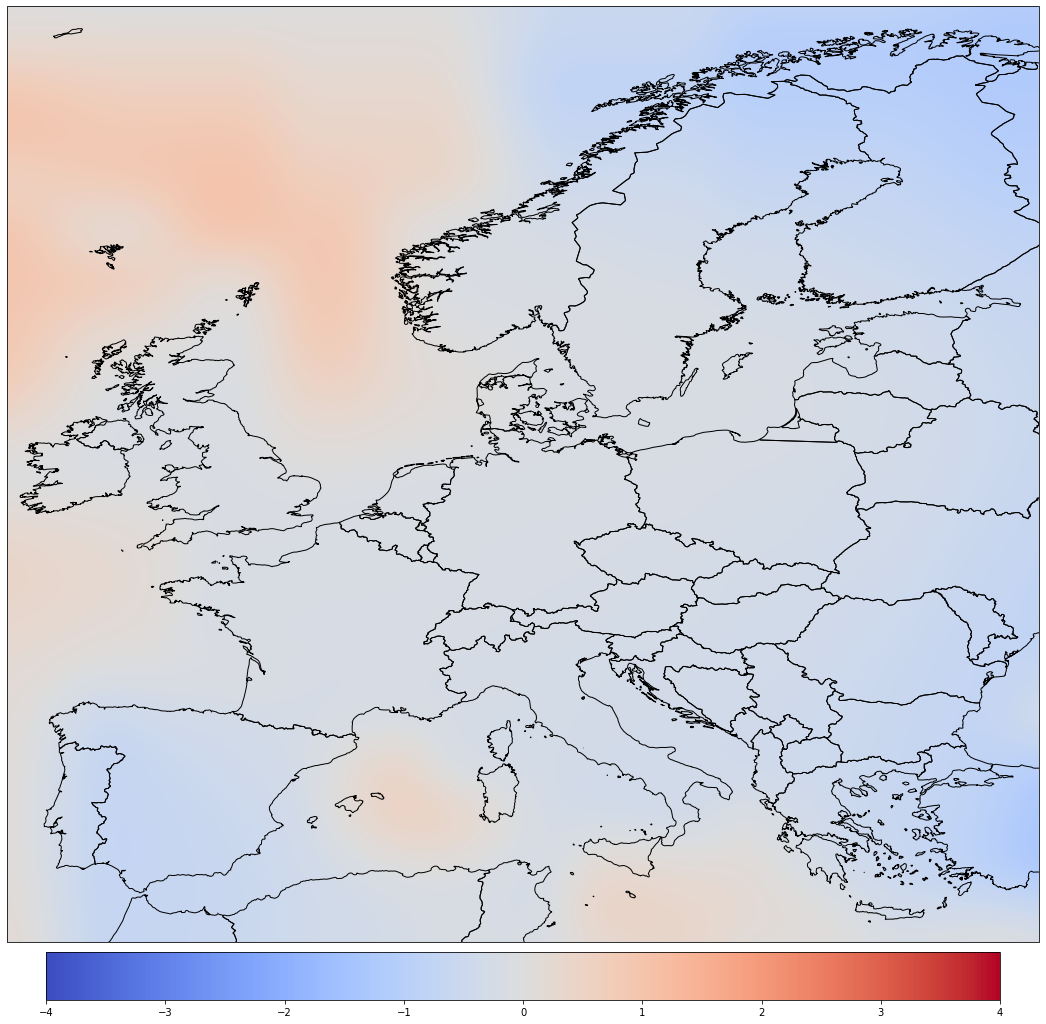

In [10]:
#Creating an animation for 1950-2020 and saving it as an MP4 video.
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.048,
    'pad': 0.01,
    'extend':'neither'
}

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0.02, bottom=0.04, right=0.98, top=0.96)
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '10m'),
              facecolor='none', edgecolor='black')
ax.set_extent([-11, 31, 34, 71])

image = anomaly.isel(time=0).plot.imshow(ax=ax, add_labels=False,
                       vmin=-4, vmax=4, cmap='coolwarm', animated=True,
                       cbar_kwargs=cbar_kwargs, interpolation='bicubic')

def animate(t):
    date =  pd.to_datetime(anomaly.sel(time=t)['time'].values)
    ax.set_title("Temperature Anomaly in " + str(date.year) + " [°C]")
    ax.title.set_fontsize(18)
    image.set_array(anomaly.sel(time=t))
    return image

ani = FuncAnimation(fig, animate, frames=anomaly['time'].values[-71:], blit=False)
ani.save("animation.mp4", fps=2, extra_args=['-vcodec','libx264', '-crf','15', '-preset','veryslow'])

### `ax.set_extent` gets modified to select specific regions.
### This gist shows what the various min/max lat/long are for the various countires that may need to be analyzed https://gist.github.com/graydon/11198540

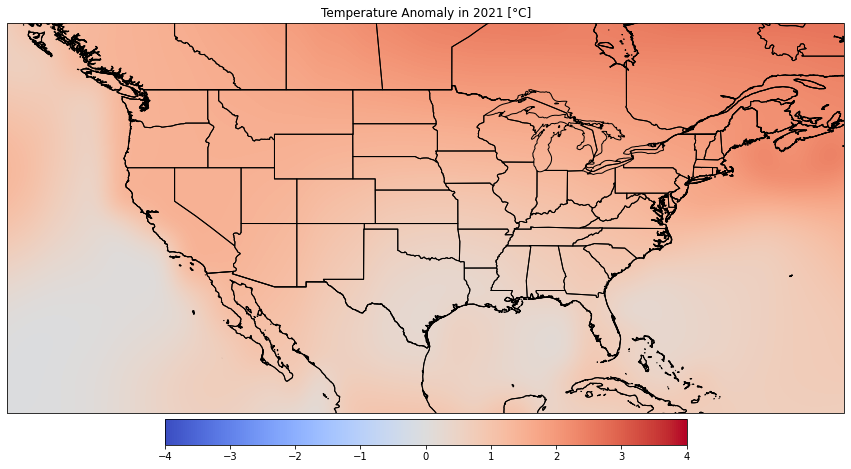

In [51]:
#Creating a static image of the U.S. temperature anomaly for a given year.
cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.048,
    'pad': 0.01,
    'extend':'neither'
}

figure = plt.figure(figsize=(15,10))
ax = figure.add_subplot(1,1,1, projection = ccrs.PlateCarree())
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '10m'),
                       facecolor='none', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent(
    [
        -135, # minimum latitude
        -60, # min longitude
        20, # max latitude
        55 # max longitude
    ],
    crs=ccrs.PlateCarree()
)

i=-1
date =  pd.to_datetime(anomaly.isel(time=i)['time'].values)
ax.set_title("Temperature Anomaly in "+ str(date.year) + " [°C]")
xr.plot.imshow(anomaly.isel(time=i), ax=ax, add_labels=False,
                   vmin=-4, vmax=4, cmap='coolwarm', 
                   cbar_kwargs=cbar_kwargs, interpolation='bicubic')
plt.savefig("usa_map.png", bbox_inches='tight', dpi=150)
plt.show()

A NetCDF file has three basic parts: metadata, dimensions and variables. Variables contain both metadata and data. 

Data Arrays can be inspected with the following:

`df.shape`  = shows how many dimensions are present in the data, along with a different lenght for each dimension
`ds.dims` = shows what each dimension is called
`ds.info()` = provides information on the metadata present in the file.


In [38]:
df.shape

(55144800, 2)

In [36]:
ds.dims

Frozen({'lat': 90, 'lon': 180, 'time': 1702, 'nv': 2})

In [5]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 90 ;
	lon = 180 ;
	time = 1702 ;
	nv = 2 ;

variables:
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	datetime64[ns] time_bnds(time, nv) ;
	float32 tempanomaly(time, lat, lon) ;
		tempanomaly:long_name = Surface temperature anomaly ;
		tempanomaly:units = K ;
		tempanomaly:cell_methods = time: mean ;

// global attributes:
	:title = GISTEMP Surface Temperature Analysis ;
	:institution = NASA Goddard Institute for Space Studies ;
	:source = http://data.giss.nasa.gov/gistemp/ ;
	:Conventions = CF-1.6 ;
	:history = Created 2021-11-10 10:02:57 by SBBX_to_nc 2.0 - ILAND=1200, IOCEAN=NCDC/ER5, Base: 1951-1980 ;
}

The following is doing the same, just using the package `netCDF4`

In [8]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [18]:
from netCDF4 import Dataset
import netCDF4 as netcdf

dataset = netcdf.netcdf_file('C:/Users/iarreola/E484/files/gistemp1200_GHCNv4_ERSSTv5.nc.gz', maskandscale = True, mmap = False)
print(data.variables.keys())

AttributeError: module 'netCDF4' has no attribute 'netcdf_file'